In [1]:
import pandas as pd
import xgboost as xgb
import numpy as np

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef

import shap

%matplotlib widget

<h1 style='text-align:center'>Dataset Loading and Preprocessing</h1>

In [2]:
def categorical_to_numeric(df, column, mapping, regex=False):
    df[column] = df[column].replace(mapping, regex=regex)


def load_preprocess(dataset_dir="input/telomere_health.csv"):
    data_raw = pd.read_csv(dataset_dir)
    data_cleaned = data_raw.drop(
        columns=[
            "marital_status",
            "education_cohort",
            "socioeconomic_status",
            "bmi_category",
            "bp",
            "hr_category",
            "rr_category",
            "health_condition",
        ]
    )

    categorical_to_numeric(
        data_cleaned,
        "cigarette_smoking",
        {
            "No information": np.nan,
            "Former Smoker": np.nan,
            "Never Smoker": 0,
            "Occasional Smoker": 1,
            "Regular Smoker": 2,
        },
    )

    categorical_to_numeric(
        data_cleaned,
        "physical_activity_cohort",
        {
            "No information": np.nan,
            "Sedentary (Inactive)": 0,
            "Minimally Active": 1,
            "Lightly Active": 2,
            "Moderately Active": 3,
            "Highly Active": 4,
        },
    )

    categorical_to_numeric(
        data_cleaned,
        "alcohol_drinking",
        {
            "No information": np.nan,
            "Former Drinker": np.nan,
            "Never Drinker": 0,
            "Occasional Drinker": 1,
            "Moderate Drinker": 2,
            "Heavy Drinker": 3,
        },
    )

    categorical_to_numeric(
        data_cleaned,
        "bp_category",
        {
            "No information": np.nan,
            "Hypotension (Low BP)": 0,
            "Normal BP": 1,
            "Elevated BP": 2,
            "Hypertension Stage 1": 3,
            "Hypertension Stage 2": 4,
            "Hypertensive Crisis": 5,
        },
    )

    categorical_to_numeric(
        data_cleaned,
        "cardiovascular_disease_diagnosis",
        {
            "^No known*": 0,
            "^Non-cardiovascular*": 0,
            "^Single.*": 1,
            "^Multi.*": 1,
        },
        regex=True,
    )

    categorical_to_numeric(
        data_cleaned,
        "cancer_diagnosis",
        {
            "^Clinically Healthy*": 0,
            "^Non-oncologic*": 0,
            "^Single.*": 1,
            "^Multi.*": 1,
        },
        regex=True,
    )

    categorical_to_numeric(
        data_cleaned,
        "depression_anxiety_diagnosis",
        {
            "^No Known*": 0,
            "^Anxiety and/or*": 1,
            "^Multi.*": 1,
        },
        regex=True,
    )

    categorical_to_numeric(
        data_cleaned,
        "allergy_diagnosis",
        {
            "^No Diagnosed*": 0,
            "^Single.*": 1,
            "^Multi.*": 1,
        },
        regex=True,
    )

    categorical_to_numeric(
        data_cleaned,
        "diabetes_diagnosis",
        {
            "^No known diagnosis*": 0,
            "^Diagnosed with*": 1,
        },
        regex=True,
    )

    categorical_to_numeric(
        data_cleaned,
        "sex",
        {
            "^Female": 0,
            "^Male": 1,
        },
        regex=True,
    )

    data_cleaned["hr"] = pd.to_numeric(data_cleaned["hr"], errors="coerce")
    data_cleaned["rr"] = pd.to_numeric(data_cleaned["rr"], errors="coerce")

    return data_cleaned

<h1 style='text-align:center'>Model Training</h1>

In [26]:
def train_model(data, to_predict, rs=0):
    y = data.pop(to_predict)
    X = data

    neg = (y == 0).sum()
    pos = (y == 1).sum()
    spw = neg / pos

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, stratify=y, random_state=rs
    )

    pipeline = Pipeline(
        [
            # ("selector", SelectFromModel(estimator=RandomForestClassifier())),
            ("scaler", StandardScaler()),
            (
                "xgb",
                xgb.XGBClassifier(
                    objective="binary:logistic", scale_pos_weight=spw, random_state=rs
                ),
            ),
        ]
    )

    cv_score = cross_val_score(pipeline, X_train, y_train, cv=10, scoring="accuracy")

    # preprocessing_pipeline = Pipeline(pipeline.steps[:-1])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    scaler = pipeline.named_steps["scaler"]
    xgb_model = pipeline.named_steps["xgb"]

    feature_names = X_train.columns

    def confusion_matrix_plot():
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
        plt.close()

    matthews_correlation_coefficient = matthews_corrcoef(y_test, y_pred)
    # xgb_tree_plot = xgb.plot_tree(pipeline.named_steps["xgb"], numtrees=0)

    X_train_scaled = scaler.transform(X_train)
    explainer = shap.TreeExplainer(xgb_model)
    shap_values = explainer.shap_values(X_train_scaled)

    def shap_plot():
        shap.plots.violin(
            shap_values,
            features=X_train_scaled,
            feature_names=feature_names,
        )

    return (
        # confusion_matrix_plot,
        matthews_correlation_coefficient,
        # xgb_tree_plot,
        feature_names,
        cv_score,
        shap_plot,
    )

In [27]:
plt.close("all")

In [28]:
telomere_health_data = load_preprocess()
mcc, f, cv, shap_plot = train_model(telomere_health_data, "cancer_diagnosis")

C:\Users\joshua\AppData\Local\Temp\ipykernel_16132\4034625128.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[column] = df[column].replace(mapping, regex=regex)


In [29]:
for n, i in enumerate(f):
    print(n, i)

0 telomere_length
1 age
2 sex
3 cigarette_smoking
4 alcohol_drinking
5 physical_activity_cohort
6 bmi
7 hr
8 rr
9 bp_category
10 cardiovascular_disease_diagnosis
11 depression_anxiety_diagnosis
12 allergy_diagnosis
13 diabetes_diagnosis


In [30]:
mcc

np.float64(0.6725833358257395)

In [31]:
print(cv.mean() * 100)

95.94285714285714


In [32]:
print(cv.std())

0.0384242738772045


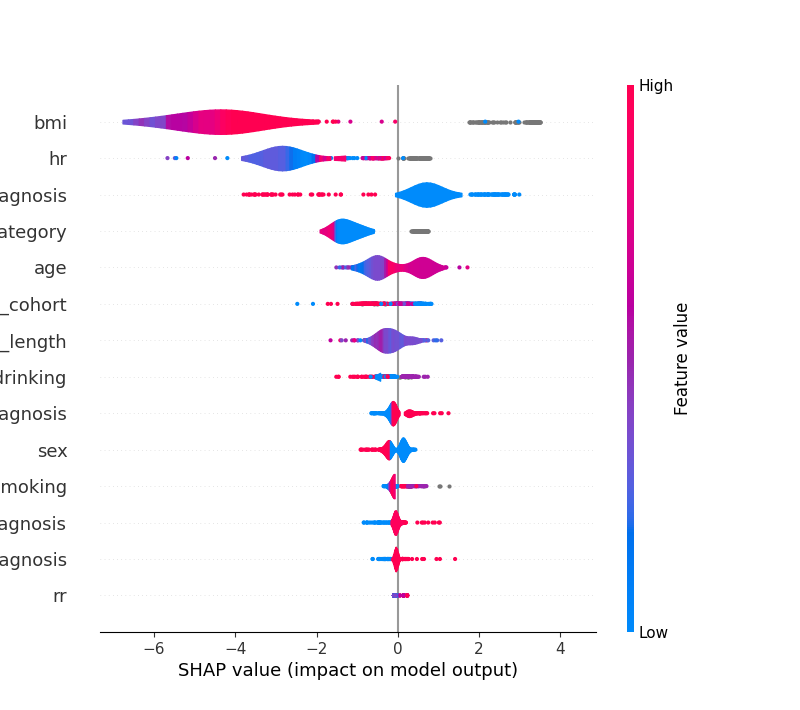

In [35]:
shap_plot()

In [34]:
plt.close("all")